In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 # for image resizing
import numpy as np
import pandas as pd

%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras
print(tf.__version__)

Using TensorFlow backend.


1.10.0


In [2]:
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
import keras.backend as K

In [3]:
IMG_DIR = 'finding-lungs-in-ct-data/2d_images/'
MASK_DIR = 'finding-lungs-in-ct-data/2d_masks/'
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
images = [x for x in sorted(os.listdir(IMG_DIR)) if x[-4:] == '.tif']

x_data = np.empty((len(images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(images):
    im = cv2.imread(IMG_DIR + name, cv2.IMREAD_UNCHANGED).astype("int16").astype('float32')
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LANCZOS4)
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    x_data[i] = im

y_data = np.empty((len(images), IMG_HEIGHT, IMG_WIDTH), dtype='float32')
for i, name in enumerate(images):
    im = cv2.imread(MASK_DIR + name, cv2.IMREAD_UNCHANGED).astype('float32')/255.
    im = cv2.resize(im, dsize=(IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
    y_data[i] = im

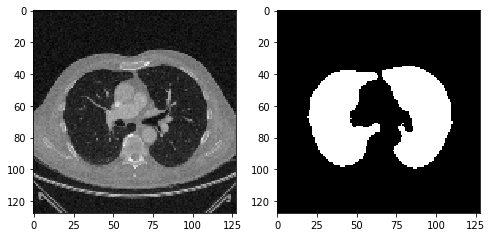

In [7]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0], cmap='gray')
plt.show()

In [8]:
x_data = x_data[:,:,:,np.newaxis]
y_data = y_data[:,:,:,np.newaxis]
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = 0.5)

In [28]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

In [29]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coef(y_true, y_pred)
    return loss

In [30]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [31]:
def conv_block(input_tensor, num_filters):
  encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = BatchNormalization()(encoder)
  encoder = Activation('relu')(encoder)
  encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation('relu')(encoder)
  return encoder

In [32]:
def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

In [33]:
def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = concatenate([concat_tensor, decoder], axis=-1)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  return decoder

In [35]:
def build_unet_model():
    inputs = Input(shape=x_train.shape[1:])
    #128
    encoder0_pool, encoder0 = encoder_block(inputs, 32)
    #64
    encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
    #32
    encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
    #16
    encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
    #8
    center = conv_block(encoder3_pool, 512)
    
    decoder3 = decoder_block(center, encoder3, 256)
    # 16
    decoder2 = decoder_block(decoder3, encoder2, 128)
    # 32
    decoder1 = decoder_block(decoder2, encoder1, 64)
    # 64
    decoder0 = decoder_block(decoder1, encoder0, 32)
    # 128
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
    
    model = Model(inputs, outputs)
    model.compile(optimizer = 'adam', loss=[dice_loss], metrics=[dice_coef, dice_loss])
    return model

unet_model = build_unet_model()
unet_model.summary()
    
    

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_66 (Conv2D)              (None, 128, 128, 32) 320         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 128, 128, 32) 128         conv2d_66[0][0]                  
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 128, 128, 32) 0           batch_normalization_75[0][0]     
__________________________________________________________________________________________________
conv2d_67 

In [36]:
def img_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(x_train, x_train, batch_size, seed=43)
    mask_generator = ImageDataGenerator(
            width_shift_range=0.1,
            height_shift_range=0.1,
            rotation_range=10,
            zoom_range=0.1).flow(y_train, y_train, batch_size, seed=43)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

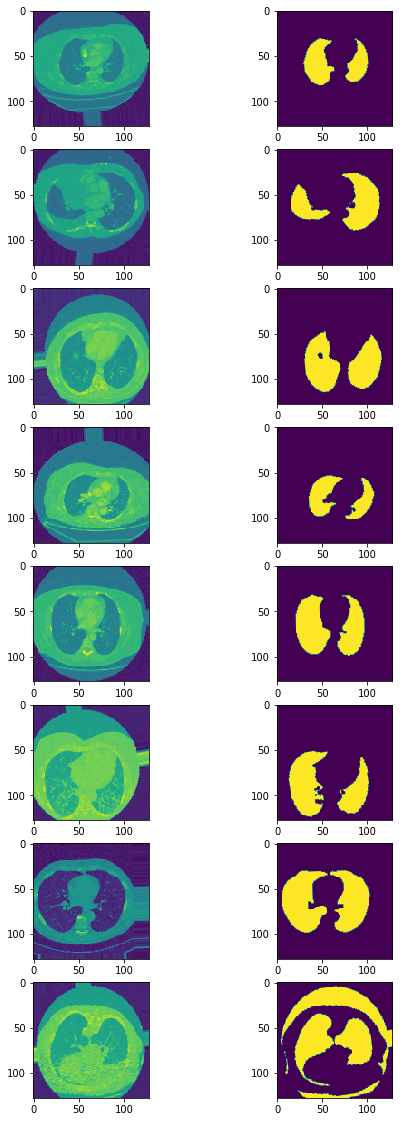

In [37]:
image_batch, mask_batch = next(img_generator(x_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [44]:
save_model_path = './lung_unet.h5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [45]:
hist = unet_model.fit_generator(img_generator(x_train, y_train, 8),
                           steps_per_epoch = 200,
                           validation_data = (x_val, y_val),
                           epochs=10, verbose=2,
                           callbacks = [cp, annealer])

Epoch 1/10
 - 31s - loss: 0.0401 - dice_coef: 0.9599 - dice_loss: 0.0401 - val_loss: 0.0254 - val_dice_coef: 0.9746 - val_dice_loss: 0.0254

Epoch 00001: val_dice_loss improved from inf to 0.02537, saving model to ./lung_unet.h5
Epoch 2/10
 - 30s - loss: 0.0384 - dice_coef: 0.9616 - dice_loss: 0.0384 - val_loss: 0.0195 - val_dice_coef: 0.9805 - val_dice_loss: 0.0195

Epoch 00002: val_dice_loss improved from 0.02537 to 0.01947, saving model to ./lung_unet.h5
Epoch 3/10
 - 30s - loss: 0.0358 - dice_coef: 0.9642 - dice_loss: 0.0358 - val_loss: 0.0196 - val_dice_coef: 0.9804 - val_dice_loss: 0.0196

Epoch 00003: val_dice_loss did not improve from 0.01947
Epoch 4/10
 - 30s - loss: 0.0350 - dice_coef: 0.9650 - dice_loss: 0.0350 - val_loss: 0.0200 - val_dice_coef: 0.9800 - val_dice_loss: 0.0200

Epoch 00004: val_dice_loss did not improve from 0.01947
Epoch 5/10
 - 30s - loss: 0.0356 - dice_coef: 0.9644 - dice_loss: 0.0356 - val_loss: 0.0156 - val_dice_coef: 0.9844 - val_dice_loss: 0.0156

Epo

In [100]:
unet_model.load_weights('./lung_unet.h5')

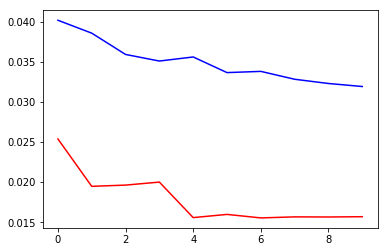

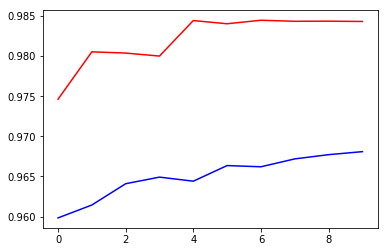

In [47]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['dice_coef'], color='b')
plt.plot(hist.history['val_dice_coef'], color='r')
plt.show()

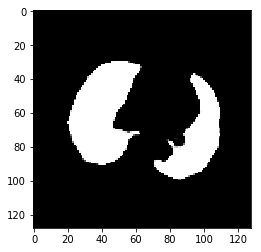

In [101]:
plt.imshow(unet_model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

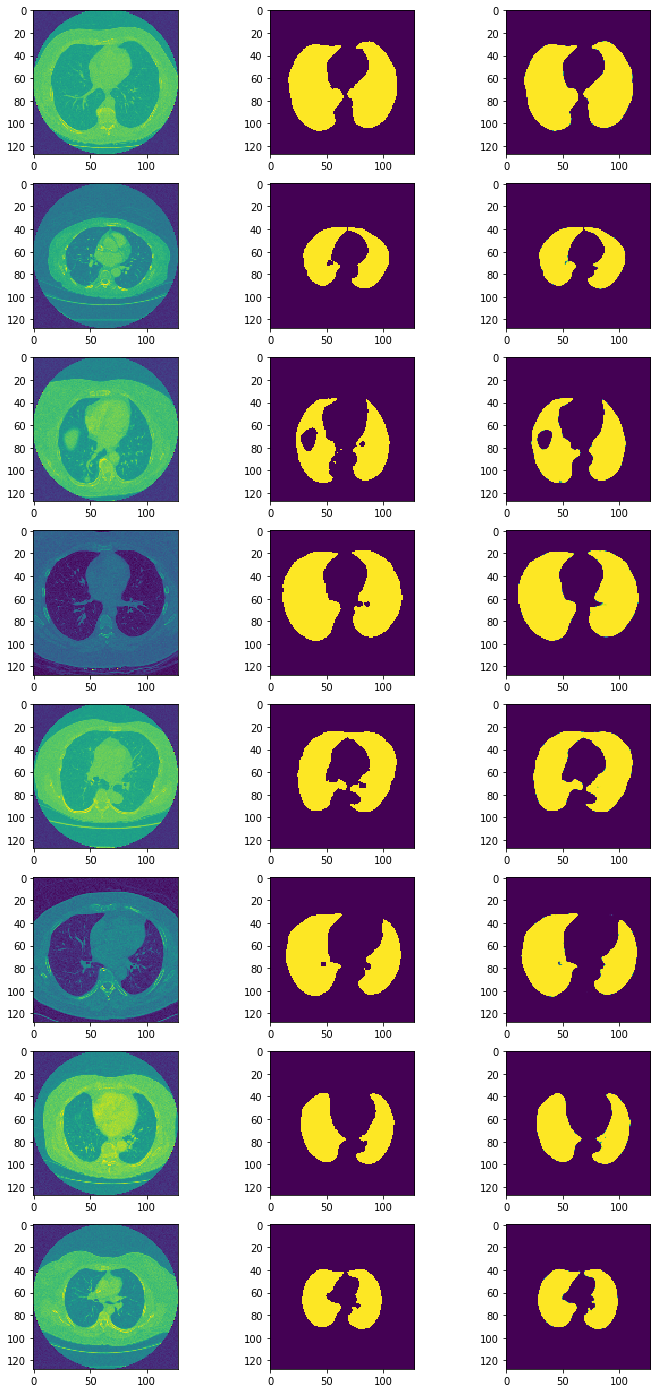

In [106]:
y_hat = unet_model.predict(x_val)
fix, ax = plt.subplots(8,3, figsize=(12,25))
for i in range(8):
    ax[i,0].imshow(x_val[i,:,:,0])
    ax[i,1].imshow(y_val[i,:,:,0])
    ax[i,2].imshow(y_hat[i,:,:,0])
plt.show()

In [87]:
def build_small_unet_model():
    input_layer = Input(shape=x_train.shape[1:])
    c1 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    l = MaxPool2D(strides=(2,2))(c1)
    c2 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
    l = MaxPool2D(strides=(2,2))(c2)
    c3 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(c3), c2], axis=-1)
    l = Conv2D(filters=128, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
    l = Conv2D(filters=64, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = Conv2D(filters=32, kernel_size=(1,1), activation='relu')(l)
    l = Dropout(0.5)(l)
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
    return model

small_unet_model = build_small_unet_model()
small_unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 128, 128, 32) 320         input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_34 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_139[0][0]                 
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, 64, 64, 64)   18496       max_pooling2d_34[0][0]           
__________________________________________________________________________________________________
max_poolin

In [88]:
save_small_model_path = './lung_small_unet.h5'
cp_small = tf.keras.callbacks.ModelCheckpoint(filepath=save_small_model_path, monitor='val_loss', save_best_only=True, verbose=1)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [95]:
small_unet_model.load_weights('./lung_small_unet.h5')

In [90]:
hist_small = small_unet_model.fit_generator(img_generator(x_train, y_train, 8),
                           steps_per_epoch = 150,
                           validation_data = (x_val, y_val),
                           epochs=15, verbose=2,
                           callbacks = [cp_small, annealer])

Epoch 1/15
 - 495s - loss: 0.4223 - dice_coef: 0.4197 - val_loss: 0.2080 - val_dice_coef: 0.6825

Epoch 00001: val_loss improved from inf to 0.20798, saving model to ./lung_small_unet.h5
Epoch 2/15
 - 14s - loss: 0.2388 - dice_coef: 0.6883 - val_loss: 0.2077 - val_dice_coef: 0.7334

Epoch 00002: val_loss improved from 0.20798 to 0.20766, saving model to ./lung_small_unet.h5
Epoch 3/15
 - 14s - loss: 0.1990 - dice_coef: 0.7497 - val_loss: 0.1477 - val_dice_coef: 0.8033

Epoch 00003: val_loss improved from 0.20766 to 0.14771, saving model to ./lung_small_unet.h5
Epoch 4/15
 - 14s - loss: 0.1548 - dice_coef: 0.8031 - val_loss: 0.1523 - val_dice_coef: 0.8318

Epoch 00004: val_loss did not improve from 0.14771
Epoch 5/15
 - 14s - loss: 0.1472 - dice_coef: 0.8192 - val_loss: 0.1514 - val_dice_coef: 0.8294

Epoch 00005: val_loss did not improve from 0.14771
Epoch 6/15
 - 14s - loss: 0.1312 - dice_coef: 0.8399 - val_loss: 0.1353 - val_dice_coef: 0.8461

Epoch 00006: val_loss improved from 0.14

In [91]:
small_unet_model.load_weights('./lung_small_unet.h5')

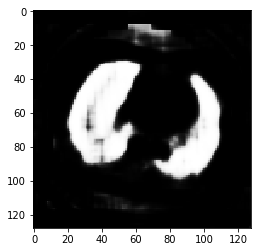

In [92]:
plt.imshow(small_unet_model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')

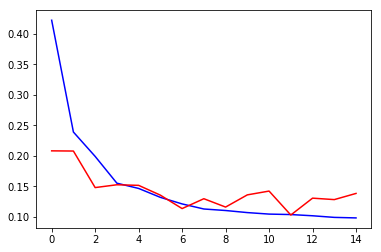

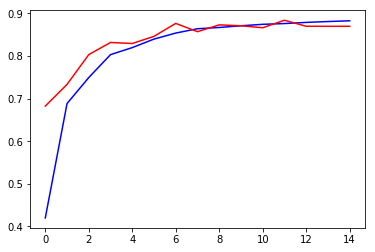

In [93]:
plt.plot(hist_small.history['loss'], color='b')
plt.plot(hist_small.history['val_loss'], color='r')
plt.show()
plt.plot(hist_small.history['dice_coef'], color='b')
plt.plot(hist_small.history['val_dice_coef'], color='r')
plt.show()

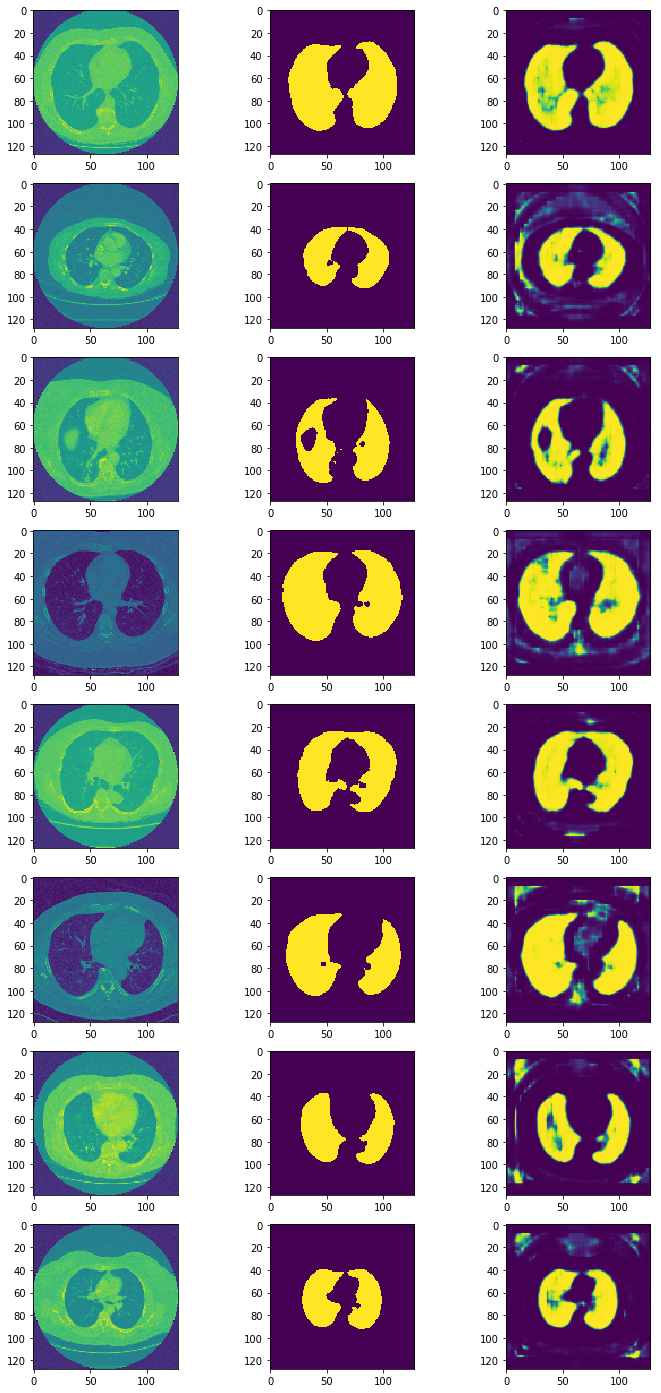

In [105]:
small_y_hat = small_unet_model.predict(x_val)
fix, ax = plt.subplots(8,3, figsize=(12,25))
for i in range(8):
    ax[i,0].imshow(x_val[i,:,:,0])
    ax[i,1].imshow(y_val[i,:,:,0])
    ax[i,2].imshow(small_y_hat[i,:,:,0])
plt.show()

In [77]:
def build_grenholm_unet_model():
    input_layer = Input(shape=x_train.shape[1:])
    c1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
    l = MaxPool2D(strides=(2,2))(c1)
    c2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
    l = MaxPool2D(strides=(2,2))(c2)
    c3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
    l = MaxPool2D(strides=(2,2))(c3)
    c4 = Conv2D(filters=32, kernel_size=(1,1), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(c4), c3], axis=-1)
    l = Conv2D(filters=32, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(l), c2], axis=-1)
    l = Conv2D(filters=24, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = concatenate([UpSampling2D(size=(2,2))(l), c1], axis=-1)
    l = Conv2D(filters=16, kernel_size=(2,2), activation='relu', padding='same')(l)
    l = Conv2D(filters=64, kernel_size=(1,1), activation='relu')(l)
    l = Dropout(0.5)(l)
    output_layer = Conv2D(filters=1, kernel_size=(1,1), activation='sigmoid')(l)
    
    model = Model(input_layer, output_layer)
    model.compile(optimizer=Adam(2e-4), loss='binary_crossentropy', metrics=[dice_coef])
    return model

grenholm_unet_model = build_grenholm_unet_model()
grenholm_unet_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 128, 128, 8)  80          input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 64, 64, 8)    0           conv2d_130[0][0]                 
__________________________________________________________________________________________________
conv2d_131 (Conv2D)             (None, 64, 64, 16)   1168        max_pooling2d_31[0][0]           
__________________________________________________________________________________________________
max_poolin

In [82]:
save_grenholm_model_path = './lung_grenholm_unet.h5'
cp_grenholm = tf.keras.callbacks.ModelCheckpoint(filepath=save_grenholm_model_path, monitor='val_loss', save_best_only=True, verbose=1)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)

In [83]:
hist_grenholm = grenholm_unet_model.fit_generator(img_generator(x_train, y_train, 8),
                           steps_per_epoch = 150,
                           validation_data = (x_val, y_val),
                           epochs=15, verbose=2,
                           callbacks = [cp_grenholm, annealer])

Epoch 1/15
 - 6s - loss: 0.1336 - dice_coef: 0.8448 - val_loss: 0.1183 - val_dice_coef: 0.8772

Epoch 00001: val_loss improved from inf to 0.11833, saving model to ./lung_grenholm_unet.h5
Epoch 2/15
 - 6s - loss: 0.1140 - dice_coef: 0.8676 - val_loss: 0.0882 - val_dice_coef: 0.8889

Epoch 00002: val_loss improved from 0.11833 to 0.08815, saving model to ./lung_grenholm_unet.h5
Epoch 3/15
 - 6s - loss: 0.1089 - dice_coef: 0.8763 - val_loss: 0.0970 - val_dice_coef: 0.8761

Epoch 00003: val_loss did not improve from 0.08815
Epoch 4/15
 - 6s - loss: 0.0950 - dice_coef: 0.8889 - val_loss: 0.1081 - val_dice_coef: 0.8832

Epoch 00004: val_loss did not improve from 0.08815
Epoch 5/15
 - 6s - loss: 0.0959 - dice_coef: 0.8900 - val_loss: 0.1158 - val_dice_coef: 0.8784

Epoch 00005: val_loss did not improve from 0.08815
Epoch 6/15
 - 6s - loss: 0.0915 - dice_coef: 0.8957 - val_loss: 0.0879 - val_dice_coef: 0.9018

Epoch 00006: val_loss improved from 0.08815 to 0.08794, saving model to ./lung_gren

In [84]:
grenholm_unet_model.load_weights('./lung_grenholm_unet.h5')

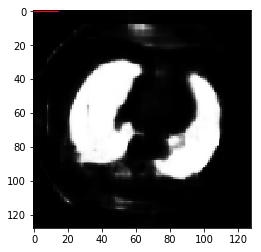

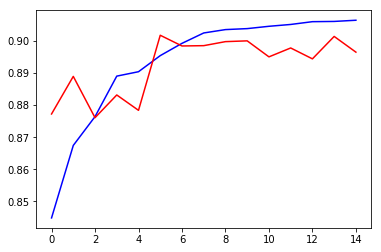

In [85]:
plt.imshow(grenholm_unet_model.predict(x_train[0].reshape(1,IMG_HEIGHT, IMG_WIDTH, 1))[0,:,:,0], cmap='gray')
plt.plot(hist_grenholm.history['loss'], color='b')
plt.plot(hist_grenholm.history['val_loss'], color='r')
plt.show()
plt.plot(hist_grenholm.history['dice_coef'], color='b')
plt.plot(hist_grenholm.history['val_dice_coef'], color='r')
plt.show()

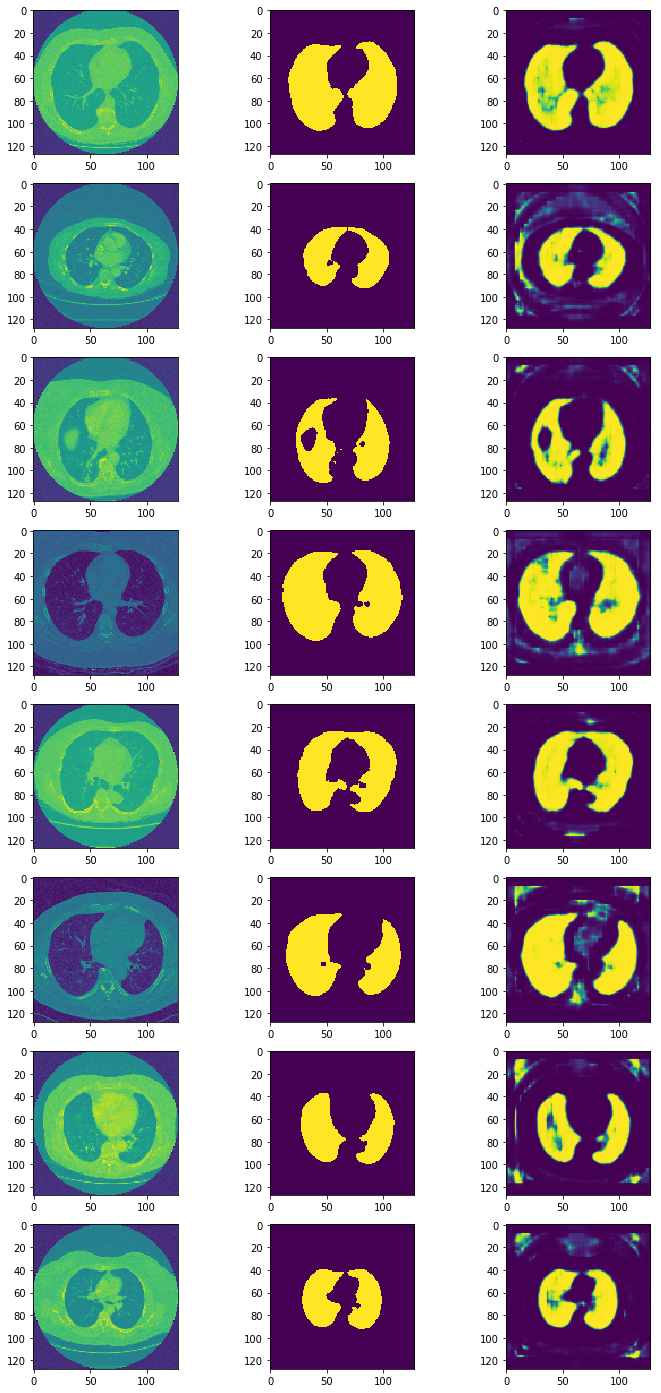

In [104]:
grenholm_y_hat = grenholm_unet_model.predict(x_val)
fix, ax = plt.subplots(8,3, figsize=(12,25))
for i in range(8):
    ax[i,0].imshow(x_val[i,:,:,0])
    ax[i,1].imshow(y_val[i,:,:,0])
    ax[i,2].imshow(small_y_hat[i,:,:,0])
plt.show()